In [ ]:
# default_exp data_man
%reload_ext autoreload
%autoreload 2
from nbdev.showdoc import *


# Data management
> Create, from FT1 and FT2, a compact data set with photon and livetime info.

### Outline

- Photons (FT1): The basic photon data is extracted to a Parquet dataset. These files
    contain the GTI info,
    
- Space craft history (FT2): pointing and Live time history: condensed to a single DataFrame

Currently under development, not used yet

In [ ]:
#export
from astropy.io import fits
import healpy
import numpy as np
import pandas as pd
pd.set_option('display.precision', 2)
import pickle
import pyarrow as pa
import pyarrow.parquet as pq

from wtlike.config import *

def get_ft1_data( config, ft1_file):

        """
        Read in a photon data (FT1) file, bin in energy and position to convert to a compact DataFrame
        
        - `ft1_file` -- A monthly file generated by J. Ballet
        
        Depends on config items
        - `theta_cut, z_cut` -- selection criteria
        - `ebins, etypes` -- define band index
        - `nside, nest` -- define HEALPix binning
         
        Returns a tuple with 

        - `tstart`, the start MET time,  and

        - DataFrame  with columns
           - `band` (uint8):    energy band index*2 + 0,1 for Front/Back 
           - `nest_index`  if nest else `ring_index` (uint32): HEALPIx index for the nside 
           - `time` (float32):    the elapsed time in s from header value TSTART in the FT1 file
           
        - gti times as an interleaved start, stop array.  
        
        For the selected events above 100 MeV, this represents 9 bytes per photon, vs. 27.
        """
      
        ebins = config.energy_edges
        etypes = config.etypes
        nside = config.nside
        nest = config.nest
        z_cut =config.z_max
        theta_cut = np.degrees(np.arccos(config.cos_theta_max))
        verbose = config.verbose
        
        ft1 = fits.open(ft1_file)
        tstart = ft1[1].header['TSTART'] 

        ## GTI - setup raveled array function to make cut
        gti_data= ft1['GTI'].data
        a,b = gti_data.START, gti_data.STOP
        gti_times = np.ravel(np.column_stack((a,b)))
        def apply_gti(time):
            x = np.digitize(time, gti_times)
            return np.bitwise_and(x,1).astype(bool)
            
        
        # extract arrays for values of interest
        data =ft1['EVENTS'].data
        glon, glat, energy, et, z, theta, time =\
             [data[x] for x in 'L B ENERGY EVENT_TYPE ZENITH_ANGLE THETA TIME'.split()]
        
        # generate event_type masks
        et_mask={}
        for ie in etypes:
            et_mask[ie]= et[:,-1-ie]
            
        data_cut = np.logical_and(theta<theta_cut, z<z_cut)
        e_cut = energy>ebins[0]
        gti_cut = apply_gti(time)
        
        if verbose>0:
            print(  f'FT1 file {ft1_file}:'\
                    f'\n\tFound {len(data):,} events, {sum(e_cut):,} with E>{ebins[0]:.0f} MeV.'\
                    f'\n\ttheta<{theta_cut:.1f} and z<{z_cut} selections remove:'\
                    f' {100.- 100*sum(data_cut)/float(len(data)):.2f} %'\
                    f'\n\tGTI cut removes {sum(~gti_cut)}'
                 )
        # apply selection
        sel = e_cut & data_cut & gti_cut
        glon_sel = glon[sel]
        glat_sel = glat[sel]
        
        # pixelate direction
        hpindex = healpy.ang2pix(nside, glon_sel, glat_sel, nest=nest, lonlat=True).astype(np.int32)
        hpname = 'nest_index' if nest else 'ring_index'
        
        # digitize energy and create band index incluing (front/back)
        ee = energy[sel]
        band_index = (2*(np.digitize(ee, ebins, )-1) + et_mask[1][sel]).astype(np.uint8)

        # combine into a recarray to feed to pandas
        recarray = np.rec.fromarrays(
                    [ band_index,  
                     hpindex,  
                     (time-tstart)[sel].astype(np.float32) ], 
                    names=['band', hpname,'time'])
        if verbose>1:
            print(f'\tReturning tstart={tstart:.0f}, {len(recarray):,} photons.')
            

            
        return  tstart, pd.DataFrame.from_records(recarray), gti_times



In [ ]:
show_doc(get_ft1_data, title_level=2)

<h2 id="get_ft1_data" class="doc_header"><code>get_ft1_data</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h2>

> <code>get_ft1_data</code>(**`config`**, **`ft1_file`**)

Read in a photon data (FT1) file, bin in energy and position to convert to a compact DataFrame

- `ft1_file` -- A monthly file generated by J. Ballet

Depdnds on config items
- `theta_cut, z_cut` -- selection criteria
- `ebins, etypes` -- define band index
- `nside, nest` -- define HEALPix binning
 
Returns a tuple with 

- `tstart`, the start MET time,  and

- DataFrame  with columns
   - `band` (uint8):    energy band index*2 + 0,1 for Front/Back 
   - `nest_index`  if nest else `ring_index` (uint32): HEALPIx index for the nside 
   - `time` (float32):    the elapsed time in s from header value TSTART in the FT1 file
   
- gti times as an interleaved start, stop array.  

For the selected events above 100 MeV, this represents 9 bytes per photon, vs. 27.

### Test with a month FT1 monthly

In [ ]:
#
from pathlib import *
config=Config()
if config.valid:
    ft1_files =sorted(list(Path('/tmp/P305_monthy').glob('*.fits')))
    if len(ft1_files)>0:
        tz,df, gti_times = get_ft1_data(config, ft1_files[0])

FT1 file /tmp/P305_monthy/P305_Source_133_zmax105.fits:
	Found 2,700,413 events, 1,714,570 with E>100 MeV.
	theta<66.4 and z<100 selections remove: 10.79 %
	GTI cut removes 0
	Returning tstart=586490000, 1,547,305 photons.


In [ ]:
#export
class ArrowDataset():
    """
    Encapsulate the  Parquet Arrow monthly dataset

    Assumes that the dataset folder is at `config.files.data`
    """
    
    def __init__(self, config):
        """
        Represent the  Parquet Arrow monthly dataset
        
        """
        # set up, assuming folder has a file `tstart.pkl` and a folder `dataset`
        self.dataroot = config.files.data
        assert self.dataroot.exists()
        self.tstarts = pickle.load(open( self.dataroot/'tstart.pkl', 'rb'))
        self.dataset = self.dataroot/'dataset'
        assert self.dataset.exists()
        if len(self.tstarts)==0:
            # empty. Is there a better way?
            self.pqset=None
            self.pdict={}
            self.month_numbers=[]
        else:
            self.pqset = t = pq.ParquetDataset(self.dataset)
            assert 'month' in t.partitions.partition_names
            u =t.partitions[0]
            self.pdict = u.dictionary
            self.month_numbers = sorted(list(map(lambda x: int(str(x)), self.pdict)))
        
    def __repr__(self):
        n = self.month_numbers        
        s = f'Parquet DataSet at "{self.dataroot}" '
        if len(n)>0:
            s += f'has {len(self.pdict)} months, {n[0]}-{n[-1]}.'
        else:
             s+= 'is empty'
        return s
    
    def get_month(self, month ):
        """Retrieve the month's tstart, and its dataframe,
             with columns: band, time, nest_index
        
        """
        try:
            table = pq.read_pandas(self.dataset, filters=[f'month == {month}'.split()])
        except Exception as e:
            print(f'Failed to read month {month} from dataset {self.dataset}: {e}', file='sys.stderr')
            raise
        df = table.to_pandas()
        
        return self.tstarts[month],df
    
    def add_month(self, month, tstart, df, gti_times, overwrite=False):
        """
        Add the data for a month to the dataset
        
        - `month` -- month index, 1-based
        - `tstart` -- MET TSTART for the month
        - `df` -- DataFrame derived from a FT1 file. Expect columns band, hpindex (or nest_index), time
        - `gti_times` -- interleaved start/stop array
        """
        if month in self.tstarts and not overwrite:
            raise Exception(f'Month {month} already in dataset: specify "overwrite" ')
        df.loc[:, 'month'] = np.uint8(month)
          
        if 'nest_index' not in df.columns:
            hpname = 'ring_index' 
            if hpname not in df.columns: hpname = 'hpindex'
            df.loc[:,'nest_index'] = healpy.ring2nest(config.nside, df[hpname]).astype(np.int32)


        table = pa.Table.from_pandas(df, preserve_index=False)
        pq.write_to_dataset(table, root_path=str(self.dataset), partition_cols=['month'])
        # update tstart
        self.tstarts[month] = tstart
        pickle.dump(self.tstarts, open( self.dataroot/'tstart.pkl', 'wb'))
        
        #update gti
        pickle.dump(gti_times, open(self.dataroot/f'gti/month_{month:}.pkl', 'wb'))
           

    def __getitem__(self, index):
        """
        """
        m = self.month_numbers[index]
        return self.get_month(m)
    
    def __len__(self):
        return len(self.month_numbers)

In [ ]:
show_doc(ArrowDataset)
show_doc(ArrowDataset.add_month)
show_doc(ArrowDataset.get_month)

<h2 id="ArrowDataset" class="doc_header"><code>class</code> <code>ArrowDataset</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ArrowDataset</code>(**`config`**)

Encapsulate the  Parquet Arrow monthly dataset

Assumes that the dataset folder is at `config.files.data`

<h4 id="ArrowDataset.add_month" class="doc_header"><code>ArrowDataset.add_month</code><a href="__main__.py#L55" class="source_link" style="float:right">[source]</a></h4>

> <code>ArrowDataset.add_month</code>(**`month`**, **`tstart`**, **`df`**, **`gti_times`**, **`overwrite`**=*`False`*)

Add the data for a month to the dataset

- `month` -- month index, 1-based
- `tstart` -- MET TSTART for the month
- `df` -- DataFrame derived from a FT1 file. Expect columns band, hpindex (or nest_index), time
- `gti_times` -- interleaved start/stop array

<h4 id="ArrowDataset.get_month" class="doc_header"><code>ArrowDataset.get_month</code><a href="__main__.py#L41" class="source_link" style="float:right">[source]</a></h4>

> <code>ArrowDataset.get_month</code>(**`month`**)

Retrieve the month's tstart, and its dataframe,
with columns: band, time, nest_index

### Check current dataset

In [ ]:
config=Config()
if config.valid:
    ds = ArrowDataset(config);
    print(ds)
    tstart, table = ds[0]

Parquet DataSet at "/home/burnett/data" has 132 months, 1-132.


In [ ]:
tstart, table.head(), table.dtypes

(239557417.0,
    band  hpindex  time  nest_index month
 0     3  4825140  2.16     7110333     1
 1     0  1514232  2.33     2896110     1
 2     4  6594842  7.42     6616337     1
 3     0  6434063  8.69     5568507     1
 4    11  8474422  9.25     6459119     1,
 band              int8
 hpindex          int32
 time           float32
 nest_index       int32
 month         category
 dtype: object)

### Test creating a new dataset


In [ ]:
! rm -rf /tmp/datatest

In [ ]:

datatest = Path('/tmp/datatest/')
datatest.mkdir(exist_ok=True)
(datatest/'dataset').mkdir(exist_ok=True)
(datatest/'gti').mkdir(exist_ok=True)
config.files.data = datatest
pickle.dump({}, open(datatest/'tstart.pkl', 'wb'))

In [ ]:
testds = ArrowDataset(config); testds

Parquet DataSet at "/tmp/datatest" is empty

In [ ]:
#
ft1_files =sorted(list(Path('/tmp/P305_monthy').glob('*.fits')))
for file in ft1_files:
    month_index = int(file.name.split('_')[-2])
    tstart, df, gti_times = get_ft1_data(config, file)
    testds.add_month(month_index, tstart, df, gti_times)    

FT1 file /tmp/P305_monthy/P305_Source_133_zmax105.fits:
	Found 2,700,413 events, 1,714,570 with E>100 MeV.
	theta<66.4 and z<100 selections remove: 10.79 %
	GTI cut removes 0
	Returning tstart=586490000, 1,547,305 photons.
FT1 file /tmp/P305_monthy/P305_Source_134_zmax105.fits:
	Found 2,887,222 events, 1,855,779 with E>100 MeV.
	theta<66.4 and z<100 selections remove: 10.00 %
	GTI cut removes 0
	Returning tstart=589120000, 1,689,811 photons.


In [ ]:
ls -l $datatest/*/*

-rw-rw-r-- 1 burnett burnett 7581 Dec 31 07:20  /tmp/datatest/gti/month_133.pkl
-rw-rw-r-- 1 burnett burnett 7581 Dec 31 07:20  /tmp/datatest/gti/month_134.pkl

'/tmp/datatest/dataset/month=133':
total 14424
-rw-rw-r-- 1 burnett burnett 14768692 Dec 31 07:20 1930996fcb894a09991e0b3fa374c2b8.parquet

'/tmp/datatest/dataset/month=134':
total 15644
-rw-rw-r-- 1 burnett burnett 16016754 Dec 31 07:20 a642ed9894204e11990f7163a742a660.parquet


In [ ]:
#
config.files.data = datatest
testds = ArrowDataset(config); print(testds)


Parquet DataSet at "/tmp/datatest" has 2 months, 133-134.


tstart: 586490000.0
    band  nest_index  time month
0     2     4900853  0.85   133
1    16     2980452  1.33   133
2     3     7786667  4.16   133
3     5     4892797  6.15   133
4     2     4871984  6.28   133
tstart: 589120000.0
    band  nest_index   time month
0     2     6976266   3.17   134
1     6     6917968   3.32   134
2     2     1302157   4.04   134
3     1     5504538   5.57   134
4     3     5693792  10.97   134


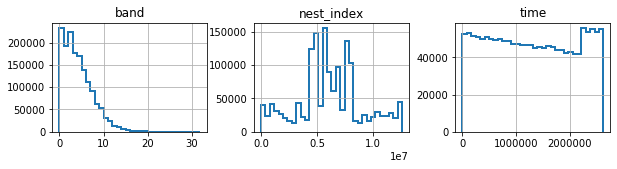

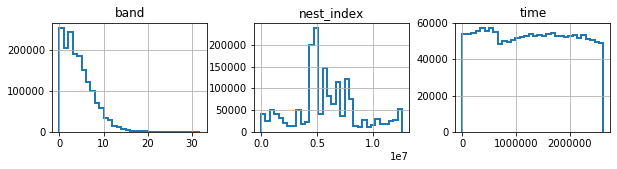

In [ ]:
for tstart, df in testds:
    print(f'tstart: {tstart}\n {df.head()}')
    df.hist('band time nest_index'.split(),bins=32, 
             layout=(1,3), figsize=(10,2),lw=2);

### Code to create DF around a source

In [ ]:
#export
# 
def get_photons_near_source(config, source, dataset_part):
    """
    Select the photons near a source
    
    - source : a PointSource object
    - dataset_part : a partition (month) of the Arrow photon dataset
    
    Returns a DF with 
    - `band` index, 
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing 
    - `radius` distance in deg from source direction
    """
    
    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix
    
    center, conepix = _cone(config,source)
    tzero, df = dataset_part
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)

    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Processing photons from month {df.month[0]}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone]

    # distance from center for all accepted photons
    ll,bb = healpy.pix2ang(config.nside, dfc.nest_index,  nest=True, lonlat=True)
    cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
    t2 = np.degrees(np.array(np.sqrt((1.-np.dot(center, cart(ll,bb)))*2), np.float32))
    in_cone = t2<config.radius

    if config.verbose>2:
        print(f'\tGeometric cone cut: select {sum(in_cone)}')
    # assume all in the GTI (should check)

    # times: convert to double, add to start, convert to MJD
    time = MJD(np.array(dfc.time, float)+tstart)

    # assemble the DataFrame, remove those outside the radius
    out_df = pd.DataFrame(np.rec.fromarrays(
        [np.array(dfc.band), time, dfc.nest_index, t2],
        names='band time pixel radius'.split()))[in_cone]
    return out_df

In [ ]:
show_doc(get_photons_near_source)

<h4 id="get_photons_near_source" class="doc_header"><code>get_photons_near_source</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>get_photons_near_source</code>(**`config`**, **`source`**, **`dataset_part`**)

Select the photons near a source

- source : a PointSource object
- dataset_part : a partition (month) of the Arrow photon dataset

Returns a DF with 
- `band` index, 
- `time` in MJD (added tstart and converted from MET)
- `pixel` index, nest indexing 
- `radius` distance in deg from source direction

### Test with an extracted month from the test dataset

Processing photons from month 133:
	Pixel cone cut: select 23523 from 1547305 (1.5%)
	Geometric cone cut: select 17698
   band      time    pixel  radius
1     1  58728.56  6794882    6.67
2     0  58728.56  6710273    5.40
3     8  58728.56  6739188    0.53
5     0  58728.56  6716453    2.32
6     7  58728.56  6708899    4.55


band        uint8
time      float64
pixel       int32
radius    float32
dtype: object

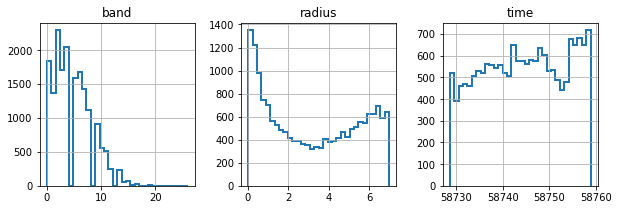

In [ ]:
#
source=PointSource('Geminga')
config.radius=7
config.verbose=3
out_df = get_photons_near_source(config, source, testds[0] )
print(out_df.head())
out_df.hist('band time radius'.split(),layout=(1,3),figsize=(10,3),bins=32, lw=2);out_df.dtypes

In [ ]:
#export
def get_ft2_info(config, ft2_file_path, gti=None):
    """Process a set of FT2 files, with S/C history data
    
    Parameters:
    
        - config -- verbose, cos_theta_max, z_max        
        - ft2_files -- list of spacecraft files        
        - gti -- GTI object with allowed intervals or None

     """
    # combine the files into a DataFrame with following fields besides START and STOP (lower case for column)
    fields    = ['LIVETIME','RA_SCZ','DEC_SCZ', 'RA_ZENITH','DEC_ZENITH']
    ft2_files = list(ft2_file_path.glob('*.fits'))
    if config.verbose>1:
        print(f'Processing {len(ft2_files)} S/C history (FT2) files in {ft2_file_path}')
#         print(f'  applying cuts cos(theta) < {config.cos_theta_max},  z < {config.z_max}')
    sc_data=[]
    for filename in ft2_files:
        with fits.open(filename) as hdu:
            scdata = hdu['SC_DATA'].data
            # get times to check against MJD limits and GTI
            start, stop = [MJD(np.array(scdata.START, float)),
                           MJD(np.array(scdata.STOP, float))]
            if config.mjd_range is not None:
                a,b=  config.mjd_range
                if stop[-1]<a:
                    print(f'\tfile {filename.name}: skip, before selected range' )
                    continue
                elif start[0]>b:
                    print(f'\tfile {filename.name}: quit, beyond range')
                    break
            # apply GTI to bin center (avoid edge effects?)
            in_gti = gti(0.5*(start+stop)) if gti else np.ones(len(start), bool)
            if config.verbose>2:
                gti_check = f', {sum(in_gti)} in GTI' if gti  else ''
                print(f'\tfile {filename.name}: {len(start)} entries {gti_check}')
            t = [('start', start[in_gti]), ('stop',stop[in_gti])]+\
                [(field.lower(), np.array(scdata[field][in_gti],np.float32)) for field in fields ]
            
            sc_data.append( pd.DataFrame(dict(t) ) )
            
    return pd.concat(sc_data, ignore_index=True)

In [ ]:
show_doc(get_ft2_info, title_level=2)

<h2 id="get_ft2_info" class="doc_header"><code>get_ft2_info</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h2>

> <code>get_ft2_info</code>(**`config`**, **`ft2_file_path`**, **`gti`**=*`None`*)

Process a set of FT2 files, with S/C history data

Parameters:

    - config -- verbose, cos_theta_max, z_max        
    - ft2_files -- list of spacecraft files        
    - gti -- GTI object with allowed intervals or None

 

### Test FT2 processing

In [ ]:
#
#from wtlike.load_gti import *
config = Config()
#gti = get_gti(config)
df = get_ft2_info(config, config.files.ft2) #, gti)

Processing 13 S/C history (FT2) files in /home/burnett/work/lat-data/ft2
	file ft2_2008.fits: 362996 entries 
	file ft2_2009.fits: 874661 entries 
	file ft2_2010.fits: 889547 entries 
	file ft2_2011.fits: 882832 entries 
	file ft2_2012.fits: 881317 entries 
	file ft2_2013.fits: 885307 entries 
	file ft2_2014.fits: 894730 entries 
	file ft2_2015.fits: 890006 entries 
	file ft2_2016.fits: 890933 entries 
	file ft2_2017.fits: 888349 entries 
	file ft2_2018.fits: 842824 entries 
	file ft2_2019.fits: 737029 entries 
	file ft2_2020.fits: 521162 entries 


In [ ]:

len(df), df.head(), df.dtypes

(10441693,
       start      stop  livetime  ra_scz  dec_scz  ra_zenith  dec_zenith
 0  54682.65  54682.65     25.99   75.93    59.10      67.85       24.56
 1  54682.65  54682.65     25.89   78.85    58.73      69.91       24.31
 2  54682.65  54682.65     25.90   81.71    58.33      71.96       24.03
 3  54682.65  54682.65     25.88   84.53    57.90      74.00       23.72
 4  54682.65  54682.65     25.85   87.29    57.43      76.03       23.39,
 start         float64
 stop          float64
 livetime      float32
 ra_scz        float32
 dec_scz       float32
 ra_zenith     float32
 dec_zenith    float32
 dtype: object)

In [ ]:
#df.to_pickle( open('/tmp/ft2_info.pkl', 'wb'))

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01-data_man.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cells.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Thu Dec 31 07:21:14 PST 2020
